# Title:

### Planet: Understanding the Amazon from space -- *(a competition hosted on Kaggle)*
#### Use satelite data to track the human footprint in the Amazon rainforest

# Description:

Every minute, the world loses an area of forest the size of 48 football fields. And deforestation in the Amazon Basin accounts for the largest share, contributing to reduced biodiversity, habitat loss, climate change, and other devastating effects. But better data about the location of deforestation and human encroachment on forests can help governments and local stakeholders respond more quickly and effectively.

Planet, designer and builder of the world’s largest constellation of Earth-imaging satellites, will soon be collecting daily imagery of the entire land surface of the earth at 3-5 meter resolution. While considerable research has been devoted to tracking changes in forests, it typically depends on coarse-resolution imagery from Landsat (30 meter pixels) or MODIS (250 meter pixels). This limits its effectiveness in areas where small-scale deforestation or forest degradation dominate.

Furthermore, these existing methods generally cannot differentiate between human causes of forest loss and natural causes. Higher resolution imagery has already been shown to be exceptionally good at this, but robust methods have not yet been developed for Planet imagery.

In this competition, Planet and its Brazilian partner SCCON are challenging Kagglers to label satellite image chips with atmospheric conditions and various classes of land cover/land use. Resulting algorithms will help the global community better understand where, how, and why deforestation happens all over the world - and ultimately how to respond.

In [1]:
%matplotlib inline

In [2]:
# importing useful libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

In [3]:
!pwd # checking current working directory

/kaggle/working


In [4]:
# loading in the training classes, it is a dataframe mapping of image name to tags
train_classes_df = pd.read_csv("/kaggle/input/planets-dataset/planet/planet/train_classes.csv")
print(train_classes_df.shape)
train_classes_df.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
# let's check the color channels in a randomly selected image...say the image with image_name 'train_10.jpg'
train_img10 = image.load_img("/kaggle/input/planets-dataset/planet/planet/train-jpg/train_10.jpg")
train_img10.mode # checking the color channels 

'RGB'

In [6]:
!ls "/kaggle/input/planets-dataset/planet/planet/train-jpg/" | wc -l # checking the total number of images in the
                                                                     # training image folder

40479


In [7]:
test1 = !ls "/kaggle/input/planets-dataset/planet/planet/test-jpg/" | wc -l # checking total number of images in 
                                                                            # testing images folder
float(test1[0])

40669.0

In [8]:
# checking total number of images in the testing images additional folder
test_additional = !ls "/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/" | wc -l
float(test_additional[0])

20522.0

In [9]:
# loading and checking the sample submission dataframe
sample_submission = pd.read_csv("/kaggle/input/planets-dataset/planet/planet/sample_submission.csv")
print(sample_submission.shape)
sample_submission.head()

(61191, 2)


,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [10]:
# let's confirm that the sum of image files in the testing and testing-additional equals the number of images in
# the sample submission dataframe
assert sample_submission.shape[0] == float(test1[0]) + float(test_additional[0])

### Let's find the unique tags in ```train_classes``` data
- First, we create a function that adds elements of a list to a Set
- Secondly, we apply this function to the ```tags``` column of ```train_classes``` after splitting its values to a list

In [11]:
unique_labels = set()
def append_labels(tags):
    for tag in tags.split():
        unique_labels.add(tag)

train_classes = train_classes_df.copy()
train_classes['tags'].apply(append_labels)
unique_labels = list(unique_labels) # casting 'unique_labels' as a list because set isn't an
                                    # indexed data structure

In [12]:
print(unique_labels)
len(unique_labels)

['agriculture', 'habitation', 'primary', 'bare_ground', 'cloudy', 'partly_cloudy', 'selective_logging', 'blow_down', 'artisinal_mine', 'conventional_mine', 'road', 'haze', 'water', 'cultivation', 'clear', 'blooming', 'slash_burn']


17

### Let's vectorize (one hot encode) the ```tags``` in ```train_classes``` using ```unique_labels``` 

In [13]:
# let's confirm that there is no image_name duplicate in the 'train_classes' dataframe
assert len(train_classes['image_name'].unique()) == train_classes.shape[0]

In [14]:
# let's do one hot encoding (vectorize) the labels in 'train_classes'
for tag in unique_labels:
    train_classes[tag] = train_classes['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
# adding '.jpg' extension to 'image_name'
train_classes['image_name'] = train_classes['image_name'].apply(lambda x: '{}.jpg'.format(x)) 
train_classes.head()

,image_name,tags,agriculture,habitation,primary,bare_ground,cloudy,partly_cloudy,selective_logging,blow_down,artisinal_mine,conventional_mine,road,haze,water,cultivation,clear,blooming,slash_burn
0,train_0.jpg,haze primary,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,train_2.jpg,clear primary,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,train_3.jpg,clear primary,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,train_4.jpg,agriculture clear habitation primary road,1,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0


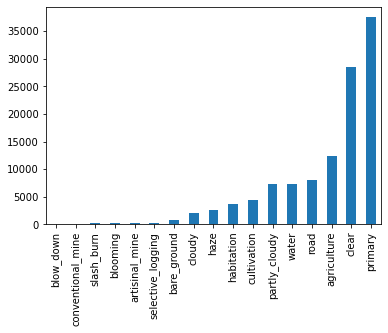

In [15]:
train_classes[unique_labels].sum().sort_values().plot.bar() # an histogram of the number of tags

In [16]:
# creating a function that generates a concurrent matrix (a matrix that contains the number of overlaps of pairs
# of tags)
def get_concurrent_matrix(tags):
    concur_df = train_classes[tags]
    concur_matrix = concur_df.T.dot(concur_df)
    mask = np.triu(np.ones((len(tags), len(tags))))
    sns.heatmap(concur_matrix, cmap=sns.cm.rocket_r, mask=mask)
    
    return concur_matrix

In [17]:
# classifying the tags into the three categories of 'atmospheric condition', 'common land cover' and 
# 'rare land cover'
atm_condition_tags = ['clear', 'partly_cloudy','cloudy', 'haze']
common_land_cover_tags = ['primary', 'water', 'habitation', 'agriculture', 'road', 'cultivation', 'bare_ground']
rare_land_cover_tags = [tag for tag in unique_labels if (tag not in atm_condition_tags) and (tag not in \
                                                                                        common_land_cover_tags)]

,clear,partly_cloudy,cloudy,haze
clear,28431,0,0,0
partly_cloudy,0,7261,0,0
cloudy,0,0,2089,0
haze,0,0,0,2697


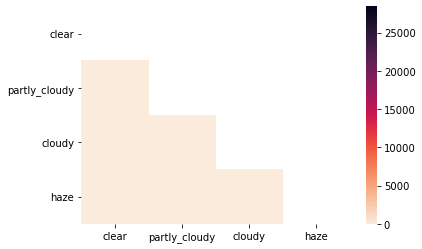

In [18]:
# concurrent matrix of atmospheric condition tags
atm_tags_concurrent_matrix = get_concurrent_matrix(atm_condition_tags) 
atm_tags_concurrent_matrix

No overlap in atmospheric condition

,primary,water,habitation,agriculture,road,cultivation,bare_ground
primary,37513,7001,3469,11972,7728,4455,683
water,7001,7411,915,2712,2125,868,206
habitation,3469,915,3660,2737,2786,895,163
agriculture,11972,2712,2737,12315,6034,3377,225
road,7728,2125,2786,6034,8071,1294,323
cultivation,4455,868,895,3377,1294,4477,89
bare_ground,683,206,163,225,323,89,862


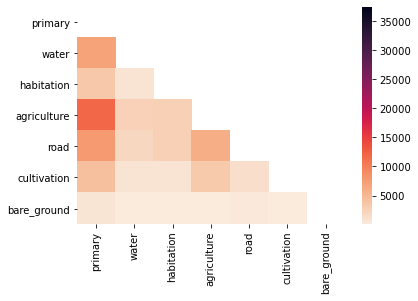

In [19]:
get_concurrent_matrix(common_land_cover_tags) # concurrent matrix of common land cover tags

```'primary'``` and ```'agriculture'``` seems to have the most overlap amongst ```common_land_cover_tags```

,selective_logging,blow_down,artisinal_mine,conventional_mine,blooming,slash_burn
selective_logging,340,1,6,0,7,2
blow_down,1,98,0,0,1,2
artisinal_mine,6,0,339,4,0,0
conventional_mine,0,0,4,100,0,0
blooming,7,1,0,0,332,2
slash_burn,2,2,0,0,2,209


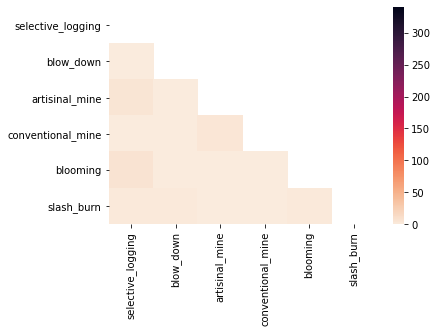

In [20]:
get_concurrent_matrix(rare_land_cover_tags) # concurrent matrix of rare land cover

Fairly overlaps but ```'selective_logging'``` and ```'blooming'``` seems to have the most overlap amongst ```'rare_land_cover_tags'``` 

,agriculture,habitation,primary,bare_ground,cloudy,partly_cloudy,selective_logging,blow_down,artisinal_mine,conventional_mine,road,haze,water,cultivation,clear,blooming,slash_burn
agriculture,12315,2737,11972,225,0,2493,65,22,38,24,6034,672,2712,3377,9150,32,119
habitation,2737,3660,3469,163,0,441,13,3,29,36,2786,129,915,895,3090,4,41
primary,11972,3469,37513,683,0,7175,340,98,324,94,7728,2670,7001,4455,27668,332,209
bare_ground,225,163,683,862,0,74,13,4,40,10,323,41,206,89,747,3,10
cloudy,0,0,0,0,2089,0,0,0,0,0,0,0,0,0,0,0,0
partly_cloudy,2493,441,7175,74,0,7261,27,13,27,28,1382,0,1295,748,0,17,33
selective_logging,65,13,340,13,0,27,340,1,6,0,151,5,49,58,308,7,2
blow_down,22,3,98,4,0,13,1,98,0,0,2,0,3,8,85,1,2
artisinal_mine,38,29,324,40,0,27,6,0,339,4,110,5,299,18,307,0,0
conventional_mine,24,36,94,10,0,28,0,0,4,100,59,2,26,4,70,0,0


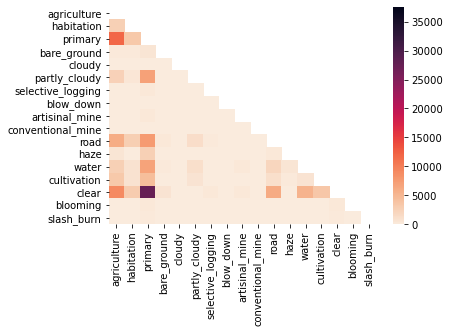

In [21]:
get_concurrent_matrix(unique_labels) # concurrent matrix of all tags

Not much overlaps amongst all tags, but ```'primary'``` and ```'clear'``` seems to have the most ovelap

In [22]:
# let's check if indeed every image must have one atmospheric condition tag
total_atm_tags = np.matmul(np.array(atm_tags_concurrent_matrix), (np.ones((4, 1)))).sum()
print(total_atm_tags)
total_atm_tags == train_classes.shape[0]

40478.0


False

In [23]:
# the above cell returned false, it seems only one image doesn't contain any atmospheric condition.
# let's check it out
image_atm_tags_df = train_classes.loc[:, ['image_name']+atm_condition_tags] 
image_without_atm_df = image_atm_tags_df.loc[image_atm_tags_df.sum(axis=1) == 0]
image_without_atm_df

,image_name,clear,partly_cloudy,cloudy,haze
24448,train_24448.jpg,0,0,0,0


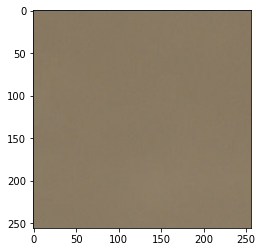

In [24]:
# let's view this image without any atmospheric condition
image_without_atm_name = image_without_atm_df.loc[24448, 'image_name']
image_without_atm = io.imread('/kaggle/input/planets-dataset/planet/planet/train-jpg/{}'.format( \
                                                                                    image_without_atm_name))
plt.imshow(image_without_atm)

In [25]:
# let's checkout the tags associated with this image above
train_classes_df[train_classes_df['image_name'] == image_without_atm_name[:-4]]

,image_name,tags
24448,train_24448,water


The data says it is water, does it look like one? Perhaps it is a dirty water or some random noise!

In [26]:
# let's view a sample image say 'train_10.jpg' 
image_number = 10
sample_img = io.imread('/kaggle/input/planets-dataset/planet/planet/train-jpg/train_{}.jpg'.format(image_number))
r, g, b = sample_img[:, :, 0], sample_img[:, :, 1], sample_img[:, :, 2]
sample_img.shape

(256, 256, 3)

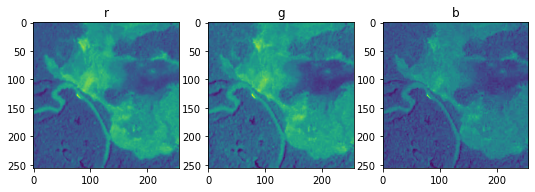

In [27]:
fig = plt.figure()
fig.set_size_inches(12, 4)
for ind, (img, channel) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'))):
    a = fig.add_subplot(1, 4, ind+1)
    a.set_title(channel)
    plt.imshow(img)
    
# displaying the red, green and blue channels seperately

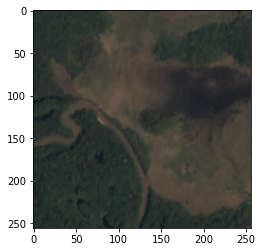

In [28]:
plt.imshow(sample_img) # displaying all channels at once

In [29]:
y_col = list(train_classes.columns[2:]) # storing the tags column names as a variable

# initializing an image generator with some data augumentation
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=45, horizontal_flip=True, \
                                            vertical_flip=True, zoom_range=0.2)

# loading images from dataframe
X = image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=1, batch_size=128)

Found 40479 validated image filenames.


In [30]:
# X is an iterable, It contains 317 batches, each batch contains 128 images and labels because 
#40479 / 128 is 316 remainder 31 each image is of shape (128, 128, 3), each label is of shape (17, )

# let's abitrarily view an image
x109 = X[0][0][109] # first batch, images, 109th image
y109 = X[0][1][109] # first batch, labels, 109th label
print("each image's shape is {}".format(x109.shape))
print("each label's shape is {}".format(y109.shape))
print('we have {} batches'.format(len(X)))
print('each batch has {} images/labels'.format(X[0][0].shape[0]))
print('40479/128 is {:.2F}, so the last batch will have {} images/labels'.format(40479/128, X[316][0].shape[0]))

each image's shape is (128, 128, 3)
each label's shape is (17,)
we have 317 batches
each batch has 128 images/labels
40479/128 is 316.24, so the last batch will have 31 images/labels


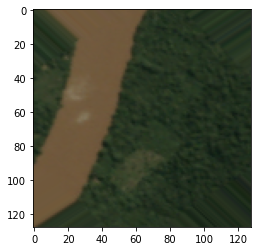

In [31]:
plt.imshow(x109/255) # divided by 255 so the image can be displayed

In [32]:
# importing useful deep learning libraries

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [33]:
# defining a function to calculate fbeta score

def fbeta(ytrue, ypred, beta=2, threshold=0.2, epsilon=1e-7):
    # threshold is set to 0.2 to maximize recall since f2 score is recall biased
    # epsilon is set to 1e-7 to avoide Nan values due to zero division
    
    beta_squarred = float(beta)**2
    
    ytrue = tf.cast(ytrue, tf.float32) # casts ytrue as a float
    # convert ypred to bool, then to float
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(threshold)), tf.float32) 
    
    tp = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(3.0)), tf.float32), axis=1) 
    fp = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(1.0)), tf.float32), axis=1)
    fn = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(2.0)), tf.float32), axis=1)

    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    fb = (beta_squarred+1) * precision * recall / (precision*beta_squarred + recall + epsilon)
  
    return fb

In [34]:
# creating a function to calculate multi-label accuracy 

def multi_label_acc(ytrue, ypred, threshold=0.2, epsilon=1e-7):
    # threshold is set to 0.2 to maximize recall since f2 score is recall biased
    # epsilon is set to 1e-7 to avoide Nan values due to zero division
    
    ytrue = tf.cast(ytrue, tf.float32) # casts ytrue as a float
    # convert ypred to bool, then to float
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(threshold)), tf.float32) 
    
    tp = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(3.0)), tf.float32), axis=1) 
    fp = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(1.0)), tf.float32), axis=1)
    fn = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(2.0)), tf.float32), axis=1)
    tn = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(0.0)), tf.float32), axis=1)
    
    acc = (tp+tn) / (tp+fp+fn+tn+epsilon)  
    
    return acc

In [35]:
# creating a function to build a sequential model

def build_model():
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    model = Sequential()
    model.add(BatchNormalization(input_shape=(128, 128, 3)))
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(17, activation='sigmoid'))
    opt = Adam(lr=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[multi_label_acc, fbeta])
    
    return model

In [36]:
# initializing callbacks
#early_stopping = EarlyStopping(monitor='val_fbeta', patience=15, mode='max', verbose=1)
reduced_lr = ReduceLROnPlateau(monitor='val_fbeta', patience=3, cool_down=2, mode='max')
save_best_check_point = ModelCheckpoint(filepath='best_model3.hdf5', monitor='val_fbeta', \
                                        mode='max', save_best_only=True, save_weights_only=True)

In [37]:
# initializing an image data generator object with a validation split of 80:20
train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=180, horizontal_flip=True, \
                                            vertical_flip=True, validation_split=0.2)

# generating the 80% training image data
train_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='training')

# generating the 20% validation image data
val_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [38]:
# setting step size for training and validation image data
step_train_size = int(np.ceil(train_gen.samples / train_gen.batch_size))
step_val_size = int(np.ceil(val_gen.samples / train_gen.batch_size))

In [39]:
model1 = build_model() # building a sequential model for training

#model1.load_weights('../input/my-best-model2/best_model2.hdf5')
# fitting the model
model1.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,
         epochs=50, callbacks=[reduced_lr, save_best_check_point] )

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/50
253/253 [==============================] - 344s 1s/step - loss: 0.1381 - multi_label_acc: 0.9240 - fbeta: 0.8732 - val_loss: 0.1105 - val_multi_label_acc: 0.9444 - val_fbeta: 0.9031
Epoch 2/50
253/253 [==============================] - 311s 1s/step - loss: 0.1084 - multi_label_acc: 0.9460 - fbeta: 0.9042 - val_loss: 0.1068 - val_multi_label_acc: 0.9506 - val_fbeta: 0.9063
Epoch 3/50
253/253 [==============================] - 313s 1s/step - loss: 0.1028 - multi_label_acc: 0.9489 - fbeta: 0.9102 - val_loss: 0.1091 - val_multi_label_acc: 0.9491 - val_fbeta: 0.9046
Epoch 4/50
253/253 [==============================] - 318s 1s/step - loss: 0.0989 - multi_label_acc: 0.9511 - fbeta: 0.9144 - val_loss: 0.1013 - val_multi_label_acc: 0.9506 - val_fbeta: 0.9094
Epoch 5/50
253/253 [==============================] - 314s 1s/step - loss: 0.0969 - multi_label_acc: 0.9516 - fbeta: 0.9158 - val_loss: 0.0956 - val_multi_label_ac

The model training lasted for approximately 2hrs 30mins with a best val_fbeta score of 0.925. Early stopping was triggered after the 29th epoch.

In [40]:
model2 = build_model() # building a sequential model for testing

#loading in the weights of the trained model
model2.load_weights('best_model3.hdf5')

In [41]:
# adding .jpg extension to 'image_name' in sample_submission data
sample_submission['image_name'] = sample_submission['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [42]:
# selecting the first 40669 'image_name'(s) from the submission_sample dataframe to generate image data from 
# test.jpg folder
test1_df = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)
test1_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [43]:
# initializing an image data generator object for the first 40669 images in the sample submission dataframe
test_image_gen1 = tf.keras.preprocessing.image.ImageDataGenerator()

# generating the image data for the first 40669 images in the sample submission dataframe
test_gen1 = test_image_gen1.flow_from_dataframe(dataframe=test1_df, \
            directory='../input/planets-dataset/planet/planet/test-jpg/', x_col='image_name', y_col=None, \
            batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the first 40669 images in the sample submission dataframe
step_test_size1 = int(np.ceil(test_gen1.samples / test_gen1.batch_size))

Found 40669 validated image filenames.


In [44]:
test_gen1.reset() # reseting the generator to be sure of avoiding shuffling
pred1 = model2.predict(test_gen1, steps=step_test_size1, verbose=1) # predicts the first 40669 images in the 
                                                                    # sample submission dataframe

318/318 [==============================] - 140s 442ms/step


In [45]:
test_file_names1 = test_gen1.filenames # storing the filenames (images names) of the first 40669 images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the first 40669 to tag names
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.2]), axis=1)

# converting the predictions of the first 40669 to a dataframe
result1 = pd.DataFrame({'image_name': test_file_names1, 'tags': pred_tags1})
result1.head()

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,agriculture primary cultivation clear
4,test_4.jpg,primary cloudy partly_cloudy


In [46]:
# selecting the remaining 'image_name'(s) from the submission_sample dataframe to generate image data from 
# test-additional.jpg folder
test2_df = sample_submission.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
test2_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [47]:
# initializing an image data generator object for the remaining images in the sample submission dataframe
test_image_gen2 = tf.keras.preprocessing.image.ImageDataGenerator()

# generating the image data for the remaining images in the sample submission dataframe
test_gen2 = test_image_gen2.flow_from_dataframe(dataframe=test2_df, \
            directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional/', x_col='image_name', \
            y_col=None, batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the remaining images in the sample submission dataframe
step_test_size2 = int(np.ceil(test_gen2.samples / test_gen2.batch_size))

Found 20522 validated image filenames.


In [48]:
test_gen2.reset() # reseting the generator to be sure of avoiding shuffling
pred2 = model2.predict(test_gen2, steps=step_test_size2, verbose=1) # predicts the remaining images in the 
                                                                    # sample submission dataframe

161/161 [==============================] - 87s 541ms/step


In [49]:
test_file_names2 = test_gen2.filenames # storing the filenames (images names) of the remaining images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the remaining images to tag names
pred_tags2 = pd.DataFrame(pred2)
pred_tags2 = pred_tags2.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.2]), axis=1)

# converting the predictions of the remaining to a dataframe
result2 = pd.DataFrame({'image_name': test_file_names2, 'tags': pred_tags2})
result2.head()

,image_name,tags
0,file_0.jpg,primary clear
1,file_1.jpg,agriculture habitation primary partly_cloudy road
2,file_10.jpg,primary road water clear
3,file_100.jpg,primary water clear
4,file_1000.jpg,primary clear


In [50]:
final_result = pd.concat([result1, result2]) # concatenate the predictions of the test.jpg and 
                                             # test-additional.jpg into a single dataframe
    
final_result = final_result.reset_index().drop('index', axis=1) # reseting the index of the dataframe so it 
                                                                # matches that of sample submission datafarme

print(final_result.shape)
final_result.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,agriculture primary cultivation clear
4,test_4.jpg,primary cloudy partly_cloudy


In [51]:
# confirming that the predicted images are ordered as in sample submission dataframe
assert sum(sample_submission['image_name'] == final_result['image_name']) == 61191

In [52]:
# removing the .jpg extension from 'iamge_name' column
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,agriculture primary cultivation clear
4,test_4,primary cloudy partly_cloudy


In [53]:
final_result.to_csv('sixth_submission.csv', index=False) # saving the predictions